/home/iwata/.local/share/virtualenvs/Transformer_TimeSeriesForecasting-main-LRDpDuFD/lib/python3.8/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


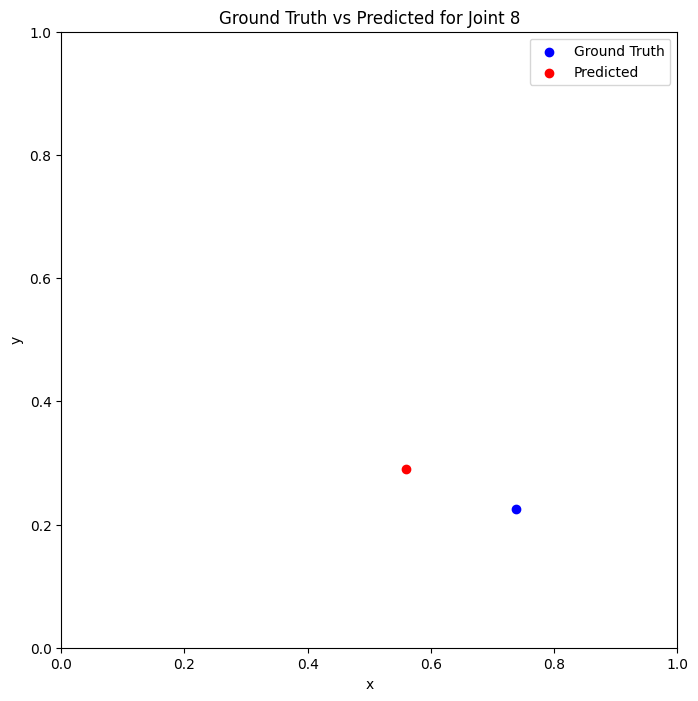

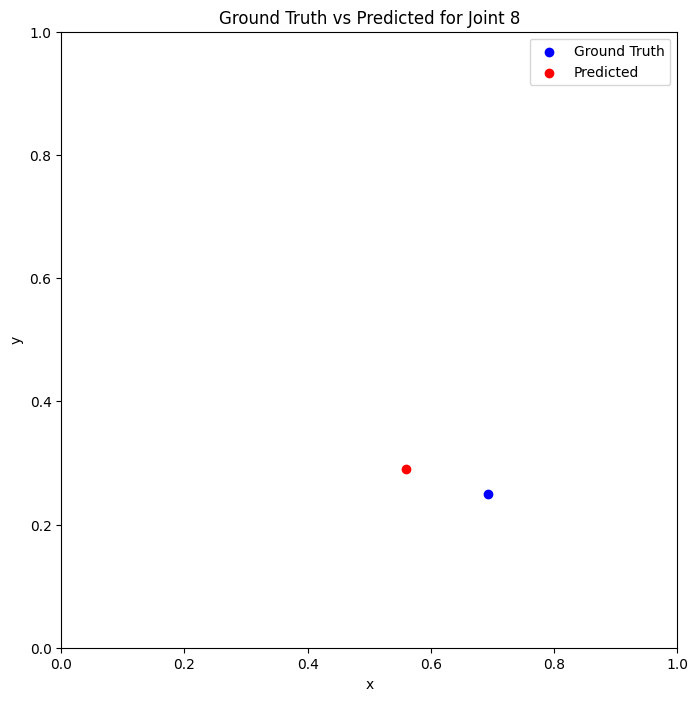

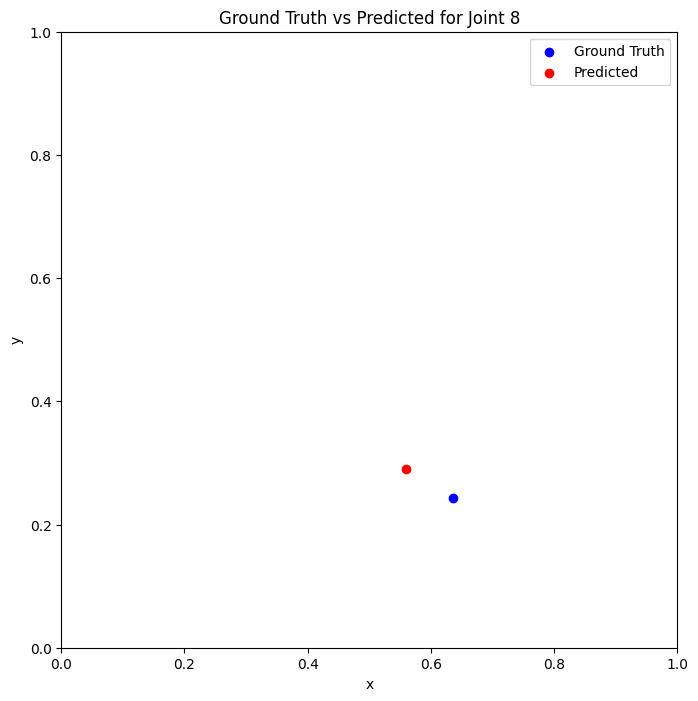

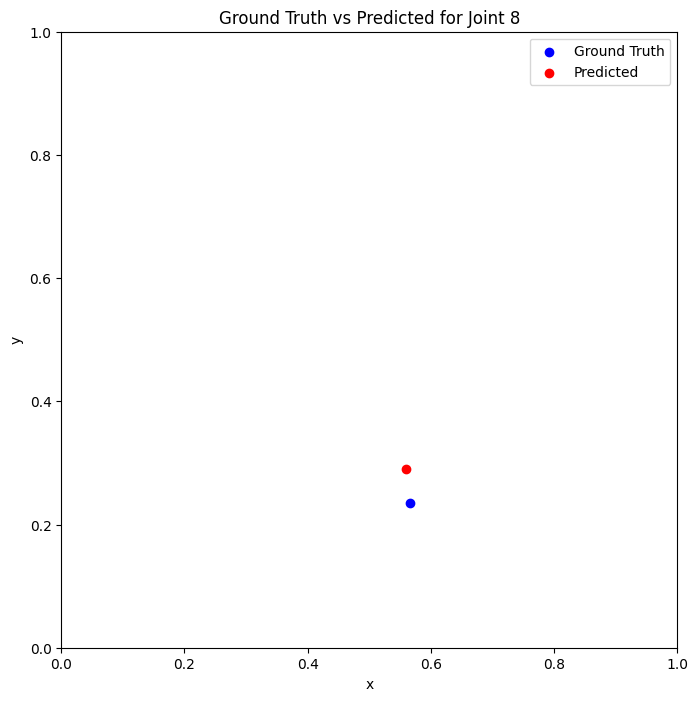

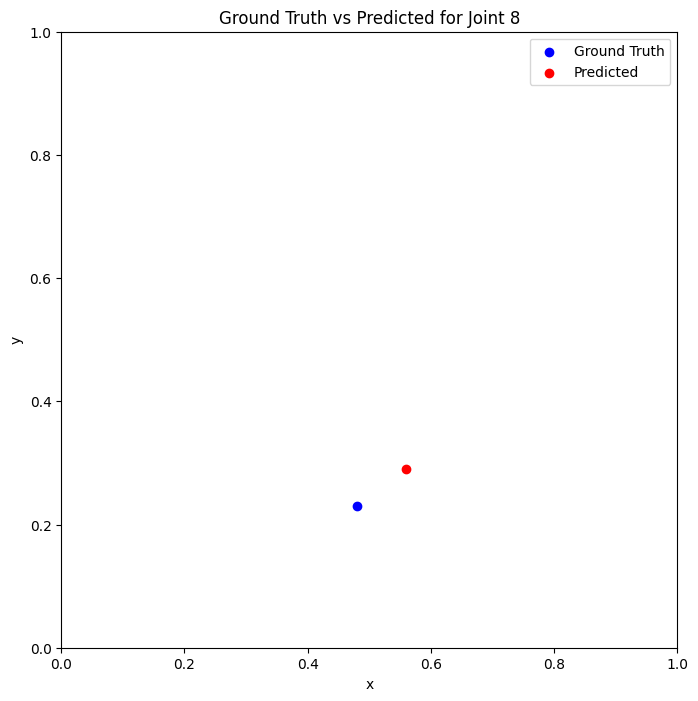

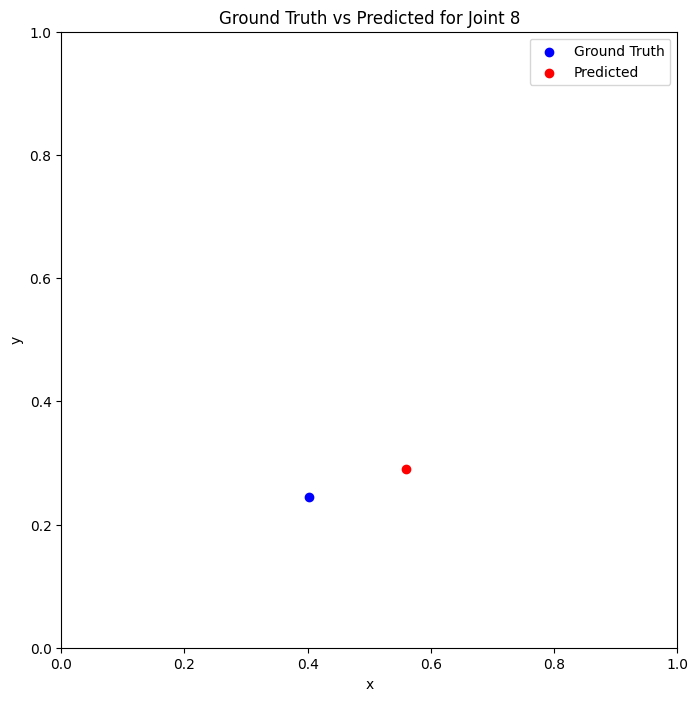

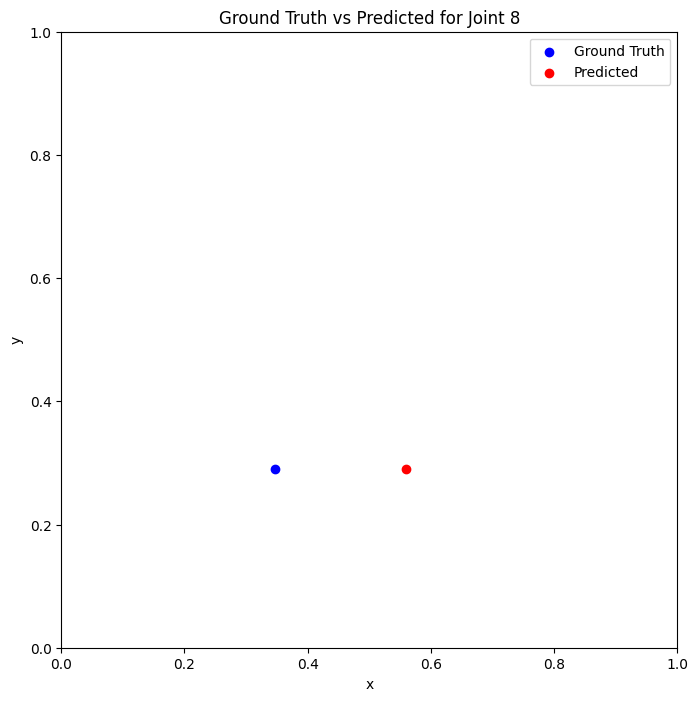

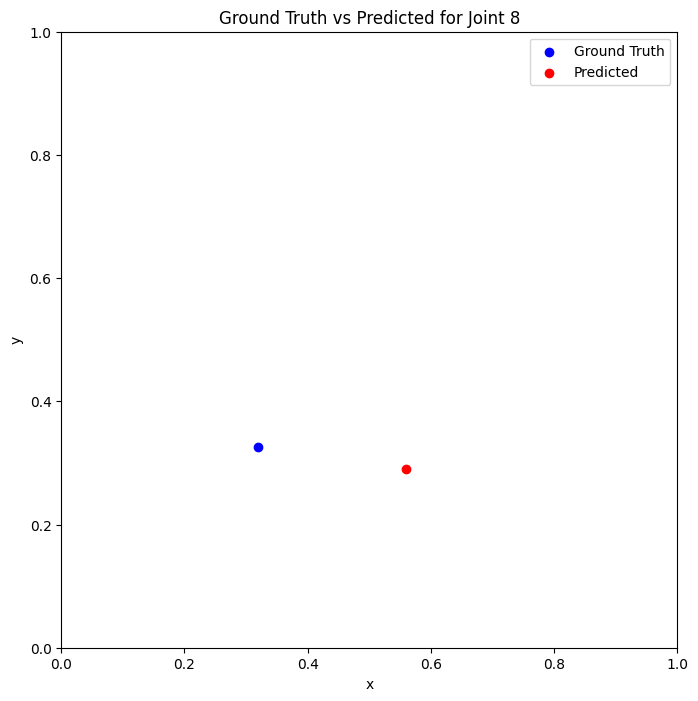

Test Loss: 0.0120
Training Time: 37.4463 seconds
Processing Time per Image: 0.0632 seconds


NameError: name 'q' is not defined

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F 
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import math
from torch.nn import TransformerEncoderLayer, LayerNorm, TransformerEncoder, TransformerDecoderLayer, TransformerDecoder

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# データの読み込みと前処理
def preprocess_data(csv_path, n_seq, num_joints, target_joint):
    df = pd.read_csv(csv_path)
    x_data = []
    y_data = []

    for i in range(len(df) - n_seq):
        x_sequence = df.iloc[i:i+n_seq][[f'{j}_{c}' for j in range(num_joints) for c in ['x', 'y', 'z']]].values.flatten()
        y_sequence = df.iloc[i+n_seq][[f'{target_joint}_x', f'{target_joint}_y', f'{target_joint}_z']].values.flatten()
        x_data.append(x_sequence)
        y_data.append(y_sequence)

    x_data = np.array(x_data, dtype=np.float32)
    y_data = np.array(y_data, dtype=np.float32)

    return x_data, y_data

# DataLoaderの使用
def create_dataloader(x_train, y_train, batch_size):
    train_dataset = TensorDataset(torch.tensor(x_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    return train_loader

# モデルのパラメータ
n_seq = 3
num_joints = 21
input_size = num_joints * 3 * n_seq  # 各関節の座標 (x, y, z) を持つ
hidden_size = 63
output_size = 3  # 8番関節の座標 (x, y, z) のみ
num_layers = 4
batch_size = 36
n_epochs = 100
n_heads = 3

# 位置エンコーディングの定義
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout: float = 0.1, max_len: int = 5000) -> None:
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.d_model = d_model

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term[:pe[:, 1::2].size(1)])  # Adjust the size for odd d_model
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

# モデルに入力するために次元を拡張する
class TokenEmbedding(nn.Module):
    def __init__(self, c_in, d_model):
        super(TokenEmbedding, self).__init__()
        self.tokenConv = nn.Linear(c_in, d_model)

    def forward(self, x):
        x = self.tokenConv(x)
        return x

# Transformerモデルのアーキテクチャ
class TransformerModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, n_heads):
        super(TransformerModel, self).__init__()
        self.embedding = TokenEmbedding(input_size, hidden_size)
        self.positional_encoding = PositionalEncoding(hidden_size)
        encoder_layer = nn.TransformerEncoderLayer(hidden_size, n_heads, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        #encoder_layer = TransformerEncoderLayer(hidden_size, n_heads)
        #self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers)
        decoder_layer = TransformerDecoderLayer(hidden_size, n_heads)
        self.transformer_decoder = TransformerDecoder(decoder_layer, num_layers)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, tgt):
        x = self.embedding(x)
        x = self.positional_encoding(x)
        memory = self.transformer_encoder(x)
        
        tgt = self.embedding(tgt)
        tgt = self.positional_encoding(tgt)
        transformer_output = self.transformer_decoder(tgt, memory)
        
        out = self.fc(transformer_output)
        return out

# モデル、損失関数、オプティマイザ
model = TransformerModel(input_size, hidden_size, output_size, num_layers, n_heads).to(device)
criterion = nn.MSELoss()
optimizer = optim.RMSprop(model.parameters())
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

# メインの処理
if __name__ == "__main__":
    # データの読み込みと前処理
    train_csv_path = 'test_10/choki_test_10/choki_test.csv'
    test_csv_path = 'test_10/choki_test_10/choki_test.csv'
    
    x_train, y_train = preprocess_data(train_csv_path, n_seq, num_joints, target_joint=8)
    x_test, y_test = preprocess_data(test_csv_path, n_seq, num_joints, target_joint=8)

    # DataLoaderの作成
    train_loader = create_dataloader(x_train, y_train, batch_size)

    # トレーニングループ
    start_time = time.time()
    for epoch in range(n_epochs):
        model.train()
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.unsqueeze(1).to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(x_batch, x_batch)  # デコーダのターゲットを入力と同じに設定
            outputs = outputs.squeeze(1)  # 出力の次元を調整
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
        scheduler.step()

    training_time = time.time() - start_time

    # テストデータで評価
    model.eval()
    with torch.no_grad():
        start_time = time.time()
        test_outputs = model(torch.tensor(x_test, dtype=torch.float32).unsqueeze(1).to(device), torch.tensor(x_test, dtype=torch.float32).unsqueeze(1).to(device))
        test_outputs = test_outputs.squeeze(1)  # 出力の次元を調整
        test_loss = criterion(test_outputs, torch.tensor(y_test, dtype=torch.float32).to(device))
        processing_time_per_image = time.time() - start_time

    # 8番の関節座標をプロット
    for sample_index in range(0, len(x_test)):
        x_test_batch = torch.tensor(x_test[sample_index:sample_index+1], dtype=torch.float32).unsqueeze(1).to(device)
        y_test_batch = torch.tensor(y_test[sample_index:sample_index+1], dtype=torch.float32).to(device)

        with torch.no_grad():
            predicted_tensor = model(x_test_batch, x_test_batch)
            predicted_tensor = predicted_tensor.squeeze(1)  # 出力の次元を調整
            predicted = predicted_tensor.cpu().numpy()

            ground_truth = y_test[sample_index]
            
            # プロットの設定
            save_path = f'/home/iwata/Pictures/hand_TF_point_{sample_index}_n{n_seq}_{n_epochs}.png'
            fig, ax = plt.subplots(figsize=(8, 8))
            
            # プロットの範囲を統一
            ax.set_xlim(0, 1)
            ax.set_ylim(0, 1)
            ax.set_aspect('equal', 'box')

            ax.scatter(ground_truth[0], ground_truth[1], color='blue', label='Ground Truth')
            ax.scatter(predicted[0][0], predicted[0][1], color='red', label='Predicted')
            
            ax.legend()
            ax.set_xlabel('x')
            ax.set_ylabel('y')
            ax.set_title('Ground Truth vs Predicted for Joint 8')

            # 画像を保存
            plt.savefig(save_path)

            # 画像を表示
            plt.show()

    print(f'Test Loss: {test_loss.item():.4f}')
    print(f'Training Time: {training_time:.4f} seconds')
    print(f'Processing Time per Image: {processing_time_per_image:.4f} seconds')
